# Applying Parametric and Non-parametric Categorical Modeling to Customer Retention

## Overview:
In this project, we apply Logistic Regressions, Decision Trees, Light GBM, and RandomForest Models to the SyriaTel Customer Churn dataset. Our findings are informed by a strong understanding of NumPy, Pandas, Scikit Learn, and statistical analysis.

## Table of contents
1. [Overview](#Overview)
2. [Business Problem](#business-problem)
3. [Data Preparation&Analysis](#data-preparation--analysis)
- 3.1 [Data Preprocessing](#data-preprocessing)
- 3.2 [Exploratory Data Analysis](#eda)
- 3.3 [Conclusion](#conclusion)
4. [Modelling](#modelling)
- 4.1 [Logistic Regression](#logistic-regression)
- 4.2 [Decision Tree Classifier](#decision-tree-regression)
- 4.3 [Random Forest Classifier](#random-forest-classifier)
- 4.4 [Light GBM](#light-gbm)

## Business Problem

Our client is SyriaTel, a telecommunications company, hoping to improve client retention. The business problem is to predict patterns in churn, and recommend strategies to curb churn.

The data has many features explored through EDA, but our analysis predominantly focuses on number of customer service calls, number of minutes spent on calls during the day, and if the customer subscribes to the international plan.

To make churn predictions, we will find the classifier model with the maximum F1 score. The F1 score is the harmonic mean of precision and recall.

Additionally we measure *AUC-ROC* comparing it with F1 score, and accuracy.




## Data Understanding

Our data source is the SyriaTel customer churn dataset. The dataset includes 20 features related to customer subscriptions to SyriaTel, such as account length, number of calls at various times, the assosciated charges to their account for those calls, and the number of calls made to customer service lines in regard to their subscription.


Some limitations we found were a lack of information on account dates, beyond length, and the dataset last being updated 6 years ago. While most features were normally distributed, 'churn', our target, had an imbalanced class we needed to corrrect.

**Our Target:**
- _churn:_ Whether the customer churned or not (True/False).

## Data Preparation & Analysis

We made a clean dataframe, clean_df, that deleted highly correlated columns, such as call charge to call minutes, and dummied categorical strings to make modeling easier.

### Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_curve,roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading in the dataset with Pandas.
df = pd.read_csv('churn.csv')

In [3]:
# Exploring the columns and values.
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
# Exploring the class, entries, non-null count, and value Dtypes.
# There is missing data in the dataframe. Numeric columns are integers and
# floats, strings, such as state and voicemail plan, are objects originally.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [5]:
# Exploring object's unique answers, it looks like all 50 states are included.
# Phone numbers function as an identifier column, each phone number is unique.
# Both the additional plans are yes or no, with imbalanced cases that favor no.
df.describe(include=object).T

,count,unique,top,freq
state,3333,51,WV,106
phone number,3333,3333,382-4657,1
international plan,3333,2,no,3010
voice mail plan,3333,2,no,2411


In [6]:
# This was confirmed by a value count, showing all 50 states and the district of DC.
df.state.value_counts()

WV    106
MN     84
NY     83
AL     80
WI     78
OH     78
OR     78
WY     77
VA     77
CT     74
MI     73
ID     73
VT     73
TX     72
UT     72
IN     71
MD     70
KS     70
NC     68
NJ     68
MT     68
CO     66
NV     66
WA     66
RI     65
MA     65
MS     65
AZ     64
FL     63
MO     63
NM     62
ME     62
ND     62
NE     61
OK     61
DE     61
SC     60
SD     60
KY     59
IL     58
NH     56
AR     55
GA     54
DC     54
HI     53
TN     53
AK     52
LA     51
PA     45
IA     44
CA     34
Name: state, dtype: int64

In [7]:
# The majority of columns are numeric, they explain plan useage features.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
account length,3333.0,101.064806,39.822106,1.00,74.00,101.00,127.00,243.00
area code,3333.0,437.182418,42.371290,408.00,408.00,415.00,510.00,510.00
number vmail messages,3333.0,8.099010,13.688365,0.00,0.00,0.00,20.00,51.00
total day minutes,3333.0,179.775098,54.467389,0.00,143.70,179.40,216.40,350.80
total day calls,3333.0,100.435644,20.069084,0.00,87.00,101.00,114.00,165.00
total day charge,3333.0,30.562307,9.259435,0.00,24.43,30.50,36.79,59.64
total eve minutes,3333.0,200.980348,50.713844,0.00,166.60,201.40,235.30,363.70
total eve calls,3333.0,100.114311,19.922625,0.00,87.00,100.00,114.00,170.00
total eve charge,3333.0,17.083540,4.310668,0.00,14.16,17.12,20.00,30.91
total night minutes,3333.0,200.872037,50.573847,23.20,167.00,201.20,235.30,395.00


In [8]:
# While info confirmed that there are no missing datapoints, and the phone numbers promised
# 3333 unique numbers, we confirmed there were no duplicate data points.
df.duplicated().sum()

0

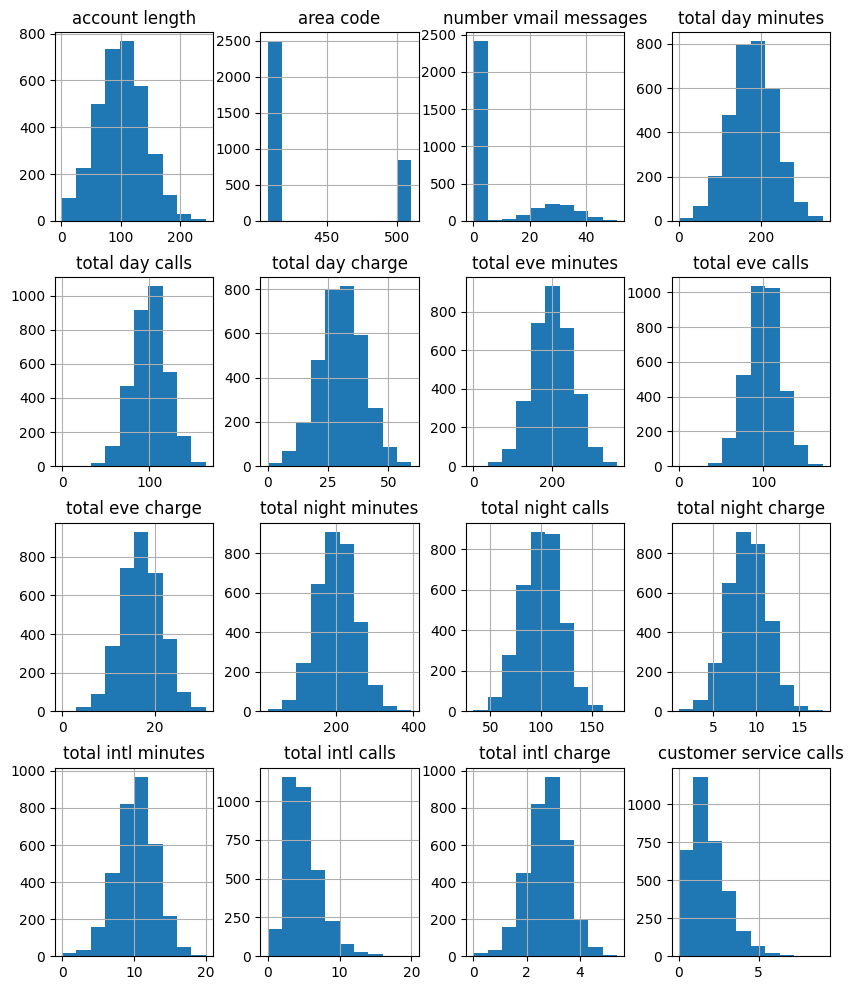

In [9]:
# We prepared histograms of the dataframe's features to better understand the distribution.
df.hist(figsize= (10,12));

This concluded our data preprocessing, and marked the beginning of feature engineering and data manipulation.

To restate our above findings, we have 3,333 rows of data pertaining to SyriaTel's telecommunication company's operations in America. There are no null or duplicate values. The distribution is normal for most columns, with the exception of 'area code', 'number of voicemail messages' and slight right skew to 'customer service calls' and 'total international calls'.

Next, we will need to transform the 'churn' column from a bool to an integer.

### Exploratory Data Analysis

In [10]:
# We changed the churn column from a boolean to an integer.
df['churn'] = df.churn.astype('int64')

In [11]:
# # We combined the minute columns to understand trends across all minutes.
# df['total_us_min'] = df[['total day minutes',
# 'total eve minutes', 'total night minutes']].sum(axis=1)

In [12]:
# # We did the same with calls. We didn't include charge because it correlated to minutes.
# df['total_us_calls'] = df[['total day calls',
# 'total eve calls', 'total night calls']].sum(axis=1)

In [13]:
# Our changes were confirmed in our updated dataframe.
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [14]:
# The head showed two area codes being attributed to four states, we looked closer and saw
# the feature was flawed. We would drop it soon.
df["area code"].value_counts()

415    1655
510     840
408     838
Name: area code, dtype: int64

In [15]:
# We decided to simplify the 51 states into five regions to simplify dummying the data if we found
# reason to inspect this feature.
West = ['WA', 'MT', 'OR', 'ID', 'WY', 'CA', 'NV', 'UT', 'CO', 'HI', 'AK']
Midwest = ['ND', 'SD', 'MN', 'WI', 'MI', 'NE', 'IA', 'IL', 'IN', 'OH', 'KS', 'MO']
Northeast = ['ME', 'VT', 'NH', 'NY', 'NJ', 'PA', 'DE', 'MD', 'RI', 'CT', 'MA']
South = ['WV', 'VA', 'DC', 'KY', 'TN', 'NC', 'AR', 'SC', 'MS', 'AL', 'GA', 'LA', 'FL']
Southwest = ['TX', 'OK', 'NM', 'AZ']

In [16]:
# This process involved defining a function called regions with state info.
def regions(state):
    if state in West:
        return 1
    if state in Midwest:
        return 2
    if state in Northeast:
        return 3
    if state in South:
        return 4
    if state in Southwest:
        return 5
    else:
        return 6


In [17]:
# The region function was added as a region column to the dataframe.
df['region'] = df['state'].apply(regions)

In [18]:
# While tuning the function, this line of code helped us identify states
# that needed to be placed in regions.
df.loc[df['region'] == 6]

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,region


In [19]:
# We could now see the regions SyriaTel had the most customers.
df.region.value_counts()

4    845
2    802
3    722
1    705
5    259
Name: region, dtype: int64

In [20]:
# We can clear state, area code, and phone number, which only served as an identifier.
df = df.drop(columns=['area code', 'state', 'phone number'])

In [21]:
# It's time to dummy our international plan and voice mail plan columns,
# dropping their original object columns.
df = pd.get_dummies(df,columns=['international plan', 'voice mail plan'], drop_first= True, dtype= int)

In [22]:
# Now we have our regions column, dummied additional subscriptions, and we've dropped
# columns that did not aid in discovery.
df.head()

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,region,international plan_yes,voice mail plan_yes
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,2,0,1
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,2,0,1
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,3,0,0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,2,1,0
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,5,1,0


In [23]:
# Let's take a look at our updated dataframe. Everything is now the right Dtypes!
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   int64  
 1   number vmail messages   3333 non-null   int64  
 2   total day minutes       3333 non-null   float64
 3   total day calls         3333 non-null   int64  
 4   total day charge        3333 non-null   float64
 5   total eve minutes       3333 non-null   float64
 6   total eve calls         3333 non-null   int64  
 7   total eve charge        3333 non-null   float64
 8   total night minutes     3333 non-null   float64
 9   total night calls       3333 non-null   int64  
 10  total night charge      3333 non-null   float64
 11  total intl minutes      3333 non-null   float64
 12  total intl calls        3333 non-null   int64  
 13  total intl charge       3333 non-null   float64
 14  customer service calls  3333 non-null   

<Axes: >

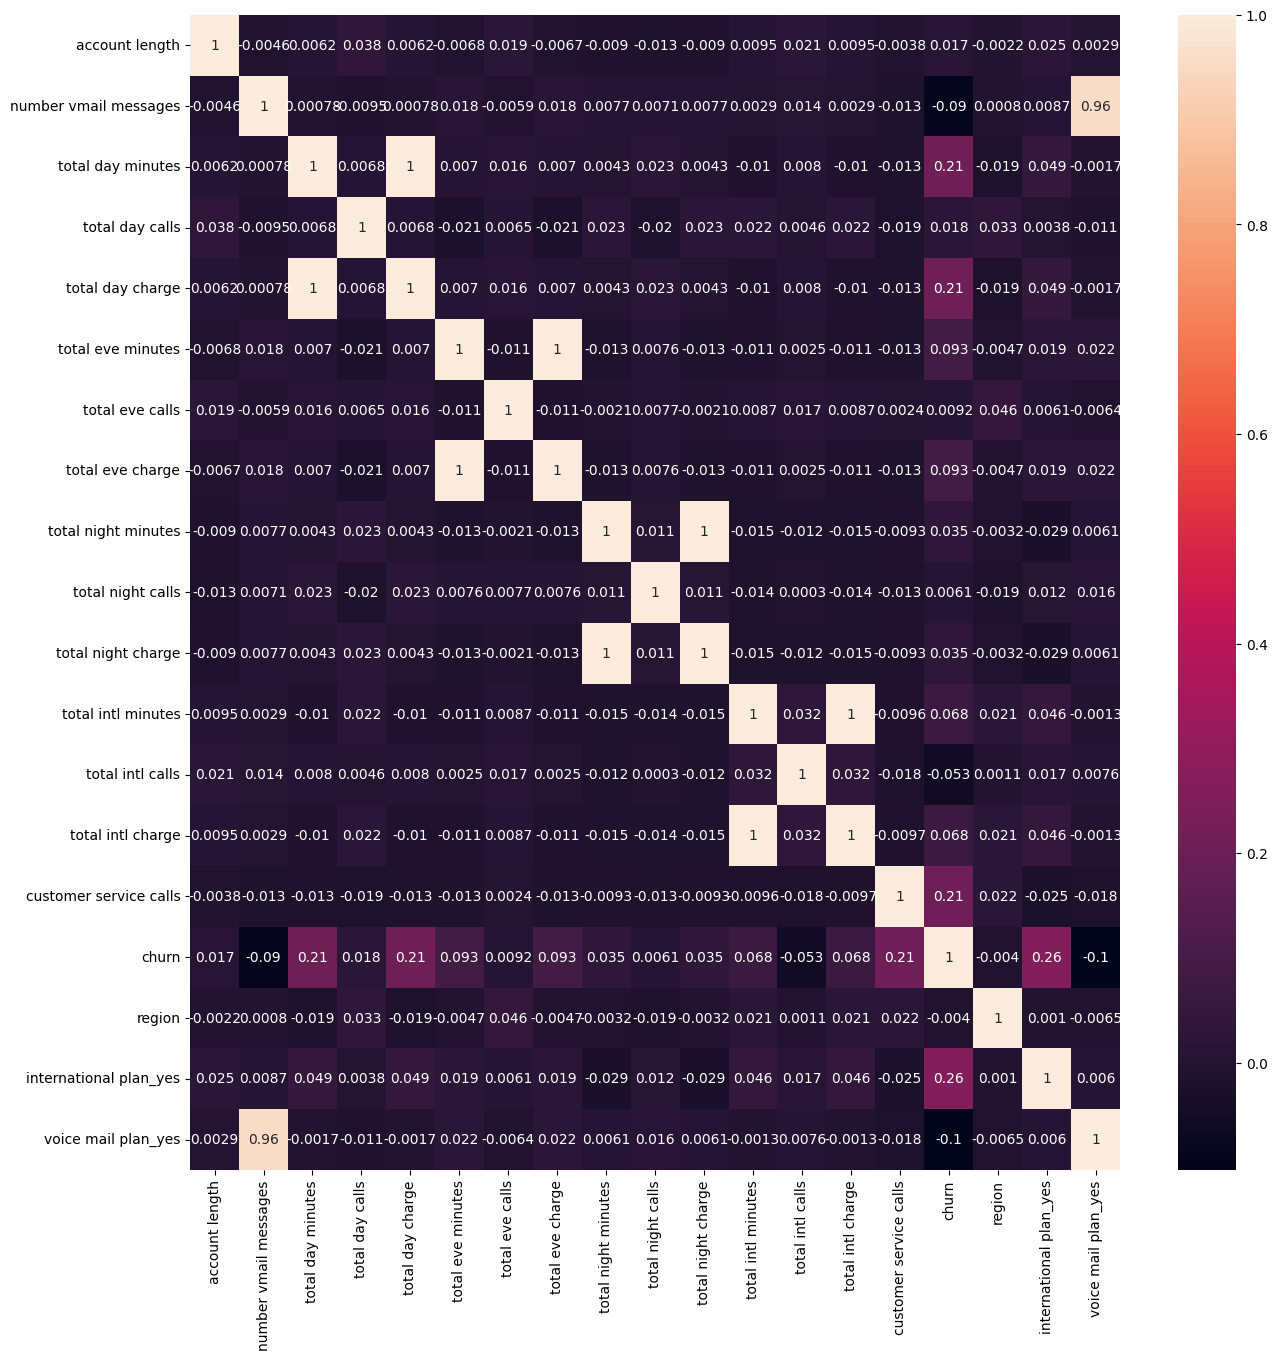

In [24]:
# A heatmap let's us compare correlations before committing to modeling.
plt.figure(figsize= (15,15))
sns.heatmap(df.corr(), annot=True)

In [25]:
# Our assumption was correct. 'Charge' columns have a correlation of 1 to their corresponding
# 'minutes' columns. We can drop them, along with number of voicemail messages, which is very similar
# to 'voicemail plan_yes'.

df = df.drop(columns=['number vmail messages', 'total day charge', 'total eve charge',
 'total night charge', 'total intl charge'])

<Axes: >

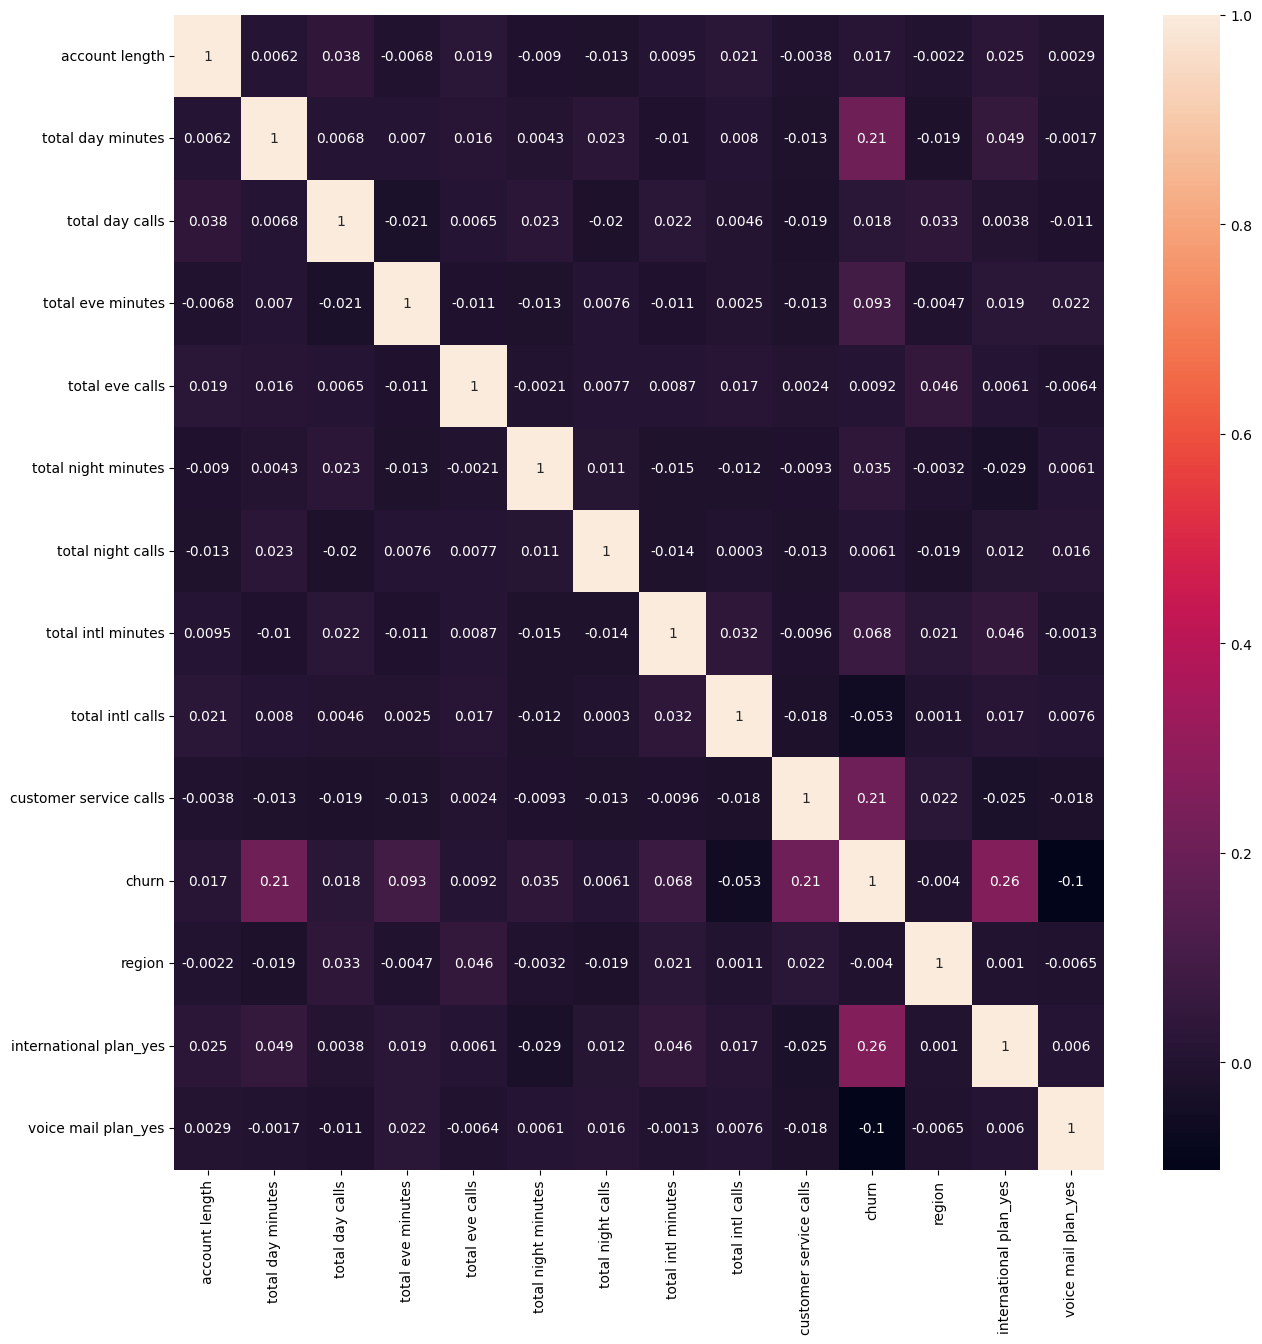

In [26]:
# Here is the resulting heatmap. It looks like
plt.figure(figsize= (15,15))
sns.heatmap(df.corr(), annot=True)

In [27]:
# While the heatmap let's us see how all columns correlate, sorting .corr by descending values
# of correlation to 'churn' will help us find important features for modeling.
df.corr()['churn'].sort_values(ascending=False)

churn                     1.000000
international plan_yes    0.259852
customer service calls    0.208750
total day minutes         0.205151
total eve minutes         0.092796
total intl minutes        0.068239
total night minutes       0.035493
total day calls           0.018459
account length            0.016541
total eve calls           0.009233
total night calls         0.006141
region                   -0.004039
total intl calls         -0.052844
voice mail plan_yes      -0.102148
Name: churn, dtype: float64

In [28]:
# Having anternational plan was the most correlated to churn. About 1 in 10 customers
# with the international plan leave SyriaTel.
df.groupby('international plan_yes').agg({'churn':['count']})

,churn
,count
international plan_yes,
0,3010
1,323


In [29]:
# About 15% of clients are leaving SyriaTel.
df.churn.value_counts(normalize=True)

0    0.855086
1    0.144914
Name: churn, dtype: float64

Conclusion

That concludes our feature engineering and EDA.  We made a region function and column to understand states, and changed the dtypes of our object columns to prepare for modeling.

While it has been cleared from this notebook, more feature engineering was conducted, such as making cumulative columns for 'total minutes' and 'total calls', but these proved to have high correlations to their interior features, and distort the overall correlation to 'churn'. For additional resources, you can reach out to Marlo on GitHub,  @0le-Worm.

## Initial Modelling

The next step was to find the best model and use it to make recommendations on how to curb churn. We started with a baseline logistic regression.

We knew LogOdds would be helpful in interpreting the odds and probability of our important feature's impact on 'churn', so we decided to confirm our important features and run logisitic regressions on them. A decision tree could help us identify our important features and follow it up with running other strong non-parametric models, such as RandomForest and LightGBM.

Together, this would create a very strong ensemble model.

In [30]:
# As identified in our business problem, our target feature was churn.
# We pulled the feature from X to predicts logodds in our Y variable.
# We performed a train_test_split to prevent data leakage.
X = df.drop("churn", axis=1)
y = df["churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345, stratify=y)

In [31]:
# We scaled with a StandardScaler and fit it to our training set, while
# transforming both our train and test.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Baseline Model

In [32]:
# We ran this through a logistic regression. We used the default parameters
# to create our baseline model. It performed poorly on both the train and test set.
lr_base = LogisticRegression(random_state=12345)

scores = cross_val_score(lr_base, X_train, y_train, cv=5, scoring="accuracy")

lr_base.fit(X_train, y_train)

lr_base_predict_train = cross_val_predict(lr_base, X_train, y_train, cv=5)
lr_base_predict_test = cross_val_predict(lr_base, X_test, y_test, cv=5)

print("lr_base_f1_train:", f1_score(y_train, lr_base_predict_train))
print("lr_base_f1_test:", f1_score(y_test, lr_base_predict_test))
print("lr_base_accuracy_test:", accuracy_score(y_test, lr_base_predict_test))
print("lr_base_mean_accuracy:", scores.mean())

lr_base_f1_train: 0.31539888682745826
lr_base_f1_test: 0.25196850393700787
lr_base_accuracy_test: 0.8575712143928036
lr_base_mean_accuracy: 0.861591163016211


In [33]:
probabilities_test_base = lr_base.predict_proba(X_test)
probabilities_one_test_base = probabilities_test_base[:, 1]
fpr_lr_base, tpr_lr_base, thresholds_lr_base = roc_curve(y_test, probabilities_one_test_base)
auc_roc_test_lr_base = roc_auc_score(y_test, probabilities_one_test_base)

### Dealing with imbalance with SMOTE

Before we could continue we had to address the imbalance in churn discovered at the end of our EDA. There are two common methods for this -- SMOTE and Class Weight.

SMOTE (Synthetic Minority Oversampling Technique) is a type of data augmentation that uses K Nearest Neighbor to draw new samples from the minority class, in our case, churn.

Class Weight helps us communicate which class is more important to us, in this case, when churn is 1. By 'balancing' these classes, the classes are treated as equals, even though churn actually only accounts for 15% of the dataset, far less than 50%.

For after comparing SMOTE and balanced weight cases across all four of our models, and mapping the AUC-ROC to best determine the stronger method of balancing our dataset, we moved forward with SMOTE.

Interest in the more extensive modeling processes can be expressed to Marlo, Tech Lead -- @0le-Worm on GitHub.

In [34]:
# Setting up SMOTE to compare between the balancing methods.
smote = SMOTE(random_state=12345)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

### Feature Importance with GradientBoostingClassifier

Our insights would be clearer to stakeholders if we focused on the fewest features with the most statistical importance. This process would be informed by results garnered from a Gradient Boosting Classifier.

In [35]:
# Prepared Gradient Boosting Classifier with SMOTE training set.
clf = GradientBoostingClassifier(n_estimators=250, learning_rate=1.0,
                                 max_depth=20, random_state=12345).fit(X_resampled, y_resampled)

print("clf_accuracy_score:", clf.score(X_test, y_test))

clf_accuracy_score: 0.8800599700149925


In [36]:
# Printed out the features importance
feature_importances = clf.feature_importances_
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance:.4f}")

feature_importances.sum()

account length: 0.0212
total day minutes: 0.2082
total day calls: 0.0281
total eve minutes: 0.0834
total eve calls: 0.0234
total night minutes: 0.0450
total night calls: 0.0295
total intl minutes: 0.0700
total intl calls: 0.0450
customer service calls: 0.1959
region: 0.0170
international plan_yes: 0.1952
voice mail plan_yes: 0.0382


1.0

In [37]:
# Chose 3 features that determine roughly 60% of churn.
important_features = ['total day minutes', 'customer service calls','international plan_yes']
X_new = df[important_features]
y_new = df["churn"]
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=12345, stratify=y)

In [38]:
scaler = StandardScaler()
X_train_new = scaler.fit_transform(X_train_new)
X_test_new = scaler.transform(X_test_new)

In [39]:
important_features[0]

'total day minutes'

### Logistic Regression -- SMOTE

In [40]:
# Prepared the optimal logistic regression.
lr = LogisticRegression(random_state=12345)

solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [5, 10, 25, 50]

param = {'solver': solver, 'max_iter': max_iter}

grid_search = GridSearchCV(lr, param, cv=5, scoring='f1')

grid_search.fit(X_train_new, y_train_new)

print("best_lr_model:", grid_search.best_estimator_)


best_lr_model: LogisticRegression(max_iter=5, random_state=12345, solver='sag')


In [41]:
# Ran optimized logistic regression with SMOTE.
lr_smote = LogisticRegression(max_iter=5, random_state=12345, solver='sag')

lr_smote_scores = cross_val_score(lr_smote, X_train_new, y_train_new, cv=5, scoring="accuracy")

lr_smote.fit(X_train_new, y_train_new)

lr_smote_predict_train = cross_val_predict(lr_smote, X_train_new, y_train_new, cv=5)
lr_smote_predict_test = cross_val_predict(lr_smote, X_test_new, y_test_new, cv=5)

print("lr_smote_f1_train:", f1_score(y_train_new,lr_smote_predict_train))
print("lr_smote_f1_test:", f1_score(y_test_new,lr_smote_predict_test))
print("lr_smote_accuracy_train:", accuracy_score(y_train_new,lr_smote_predict_train))
print("lr_smote_accuracy_test:", accuracy_score(y_test_new,lr_smote_predict_test))
print("lr_smote_mean_accuracy:", lr_smote_scores.mean())

lr_smote_f1_train: 0.2895238095238095
lr_smote_f1_test: 0.09259259259259259
lr_smote_accuracy_train: 0.8600900225056264
lr_smote_accuracy_test: 0.8530734632683659
lr_smote_mean_accuracy: 0.8600916303026469


### Decision Tree Classifier -- SMOTE

In [42]:
# Prepared the optimal decision tree with SMOTE.
dt = DecisionTreeClassifier(random_state=12345)

depth = [x for x in range(2, 21, 2)]
criterion = ['gini', 'entropy']
feat = ['sqrt', 'log2']

param = [{'max_depth':depth, 'criterion': criterion, 'max_features':feat}]

grid_search = GridSearchCV(dt, param, cv=5, scoring='f1')

grid_search.fit(X_train_new, y_train_new)

print("best_dt_model:", grid_search.best_estimator_)

best_dt_model: DecisionTreeClassifier(criterion='entropy', max_depth=6, max_features='sqrt',
                       random_state=12345)


In [43]:
# Ran the optimal decision tree with SMOTE.
dt_smote = DecisionTreeClassifier(criterion='entropy', max_depth=6, max_features='sqrt',
                       random_state=12345)

dt_smote_scores = cross_val_score(dt_smote, X_train_new, y_train_new, cv=5, scoring="accuracy")

dt_smote.fit(X_train_new, y_train_new)

dt_smote_predict_train = cross_val_predict(dt_smote, X_train_new, y_train_new, cv=5)
dt_smote_predict_test = cross_val_predict(dt_smote, X_test_new, y_test_new, cv=5)

print("dt_smote_f1_train:", f1_score(y_train_new,dt_smote_predict_train))
print("dt_smote_f1_test:", f1_score(y_test_new,dt_smote_predict_test))
print("dt_smote_accuracy_test:", accuracy_score(y_test_new,dt_smote_predict_test))
print("dt_smote_mean_accuracy:", dt_smote_scores.mean())

dt_smote_f1_train: 0.5047619047619047
dt_smote_f1_test: 0.352112676056338
dt_smote_accuracy_test: 0.8620689655172413
dt_smote_mean_accuracy: 0.8829696931368621


### Random Forest Classifier -- SMOTE

In [45]:
# # Prepared the optimal random forest classifier with SMOTE.
# rf = RandomForestClassifier(random_state=12345)

# depth = [x for x in range(2, 21, 2)]
# est = [x for x in range(40, 81, 10)]
# feat = ['log2', 'sqrt']

# param = [{'max_depth':depth, 'n_estimators':est, 'max_features':feat}]

# grid_search = GridSearchCV(rf, param, cv=5, scoring='f1')

# grid_search.fit(X_train_new, y_train_new)

# print("best_rf_model:", grid_search.best_estimator_)

best_rf_model: RandomForestClassifier(max_depth=12, max_features='log2', n_estimators=70,
                       random_state=12345)


In [46]:
# Ran the optimal random forest classifier with SMOTE.
rf_smote = RandomForestClassifier(max_depth=12, max_features='log2', n_estimators=70,
                       random_state=12345)

rf_smote_scores = cross_val_score(rf_smote, X_train_new, y_train_new, cv=5, scoring="accuracy")

rf_smote.fit(X_train_new, y_train_new)

rf_smote_predict_train = cross_val_predict(rf_smote, X_train_new, y_train_new, cv=5)
rf_smote_predict_test = cross_val_predict(rf_smote, X_test_new, y_test_new, cv=5)

print("rf_smote_f1_train:", f1_score(y_train_new,rf_smote_predict_train))
print("rf_smote_f1_test:", f1_score(y_test_new,rf_smote_predict_test))
print("rf_smote_accuracy_test:", accuracy_score(y_test_new,rf_smote_predict_test))
print("rf_smote_mean_accuracy:", rf_smote_scores.mean())

rf_smote_f1_train: 0.5106990014265335
rf_smote_f1_test: 0.4021739130434782
rf_smote_accuracy_test: 0.8350824587706147
rf_smote_mean_accuracy: 0.8713479632635567


### Light GBM -- SMOTE

In [47]:
# Prepared the optimal LightGBM model with SMOTE.
lgbm = LGBMClassifier(verbosity=-1, boosting_type='goss')

depth = [x for x in range(2, 11, 2)]
est = [x for x in range(70, 101, 10)]
rate = [0.25, 0.3, 0.4]

param = [{'max_depth':depth, 'n_estimators':est, 'learning_rate':rate}]

grid_search = GridSearchCV(lgbm, param, cv=5, scoring='f1')

grid_search.fit(X_train_new, y_train_new)

print("best_lgbm_model:", grid_search.best_estimator_)

best_lgbm_model: LGBMClassifier(boosting_type='goss', learning_rate=0.25, max_depth=2,
               n_estimators=80, verbosity=-1)


In [48]:
# Ran the optimal LightGBM model with SMOTE.
lgbm_smote = LGBMClassifier(boosting_type='goss', learning_rate=0.25, max_depth=2,
               n_estimators=80, verbosity=-1)

lgbm_smote_scores = cross_val_score(lgbm_smote, X_train_new, y_train_new, cv=5, scoring="accuracy")

lgbm_smote.fit(X_train_new, y_train_new)

lgbm_smote_predict_train = cross_val_predict(lgbm_smote, X_train_new, y_train_new, cv=5)
lgbm_smote_predict_test = cross_val_predict(lgbm_smote, X_test_new, y_test_new, cv=5)

print("lgbm_smote_f1_train:", f1_score(y_train_new,lgbm_smote_predict_train))
print("lgbm_smote_f1_test:", f1_score(y_test_new,lgbm_smote_predict_test))
print("lgbm_smote_accuracy_test:", accuracy_score(y_test_new,lgbm_smote_predict_test))
print("lgbm_smote_mean_accuracy:", lgbm_smote_scores.mean())

lgbm_smote_f1_train: 0.548238897396631
lgbm_smote_f1_test: 0.4567901234567901
lgbm_smote_accuracy_test: 0.8680659670164917
lgbm_smote_mean_accuracy: 0.889350788062764


## Comparing our four models' AUC-ROC Curves

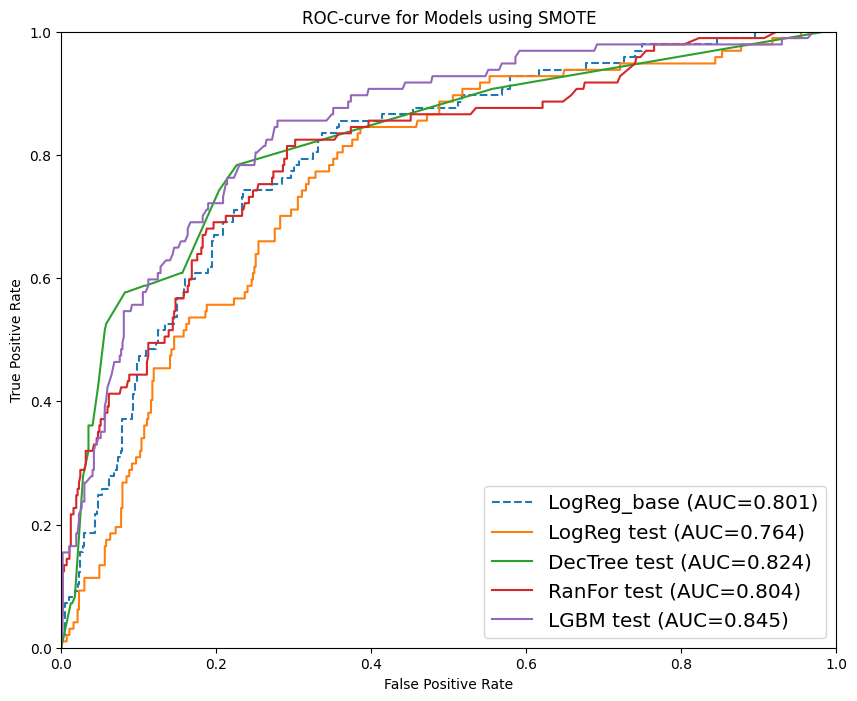

In [49]:
# Building AUC-ROC curve for all 4 SMOTE models

probabilities_test_lr_smote = lr_smote.predict_proba(X_test_new)
probabilities_one_test_lr_smote = probabilities_test_lr_smote[:, 1]
fpr_lr_smote, tpr_lr_smote, thresholds_lr_smote = roc_curve(y_test_new, probabilities_one_test_lr_smote)
auc_roc_test_lr_smote = roc_auc_score(y_test_new, probabilities_one_test_lr_smote)

probabilities_test_dt_smote = dt_smote.predict_proba(X_test_new)
probabilities_one_test_dt_smote = probabilities_test_dt_smote[:, 1]
fpr_dt_smote, tpr_dt_smote, thresholds_dt_smote = roc_curve(y_test_new, probabilities_one_test_dt_smote)
auc_roc_test_dt_smote = roc_auc_score(y_test_new, probabilities_one_test_dt_smote)

probabilities_test_rf_smote = rf_smote.predict_proba(X_test_new)
probabilities_one_test_rf_smote = probabilities_test_rf_smote[:, 1]
fpr_rf_smote, tpr_rf_smote, thresholds_rf_smote = roc_curve(y_test_new, probabilities_one_test_rf_smote)
auc_roc_test_rf_smote = roc_auc_score(y_test_new, probabilities_one_test_rf_smote)

probabilities_test_lgbm_smote = lgbm_smote.predict_proba(X_test_new)
probabilities_one_test_lgbm_smote = probabilities_test_lgbm_smote[:, 1]
fpr_lgbm_smote, tpr_lgbm_smote, thresholds_lgbm_smote = roc_curve(y_test_new, probabilities_one_test_lgbm_smote)
auc_roc_test_lgbm_smote = roc_auc_score(y_test_new, probabilities_one_test_lgbm_smote)

plt.figure(figsize=[10, 8])
plt.plot(fpr_lr_base, tpr_lr_base, linestyle='--', label=f'LogReg_base (AUC={round(auc_roc_test_lr_base, 3)})')
plt.plot(fpr_lr_smote, tpr_lr_smote, label=f'LogReg test (AUC={round(auc_roc_test_lr_smote, 3)})')
plt.plot(fpr_dt_smote, tpr_dt_smote, label=f'DecTree test (AUC={round(auc_roc_test_dt_smote, 3)})')
plt.plot(fpr_rf_smote, tpr_rf_smote, label=f'RanFor test (AUC={round(auc_roc_test_rf_smote, 3)})')
plt.plot(fpr_lgbm_smote, tpr_lgbm_smote, label=f'LGBM test (AUC={round(auc_roc_test_lgbm_smote, 3)})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right', fontsize='x-large')
plt.title("ROC-curve for Models using SMOTE")
plt.show()

Our Best Model: Light GBM with SMOTE

In [50]:
print('Metrics for the best fitted Light GBM Model')
print("F1 Training Score", f1_score(y_train_new,lgbm_smote_predict_train))
print("F1 Testing Score", f1_score(y_test_new,lgbm_smote_predict_test))
print("Accuracy Score:", accuracy_score(y_test_new,lgbm_smote_predict_test))
print("Mean Accuracy:", lgbm_smote_scores.mean())

Metrics for the best fitted Light GBM Model
F1 Training Score 0.548238897396631
F1 Testing Score 0.4567901234567901
Accuracy Score: 0.8680659670164917
Mean Accuracy: 0.889350788062764


We have now addressed overfitting by limiting our dataframe to three features (international plan yes, customer service calls, and total day minutes), and underrepresentation of churn with SMOTE. Since we have balanced the dataset, we can move forward using accuracy as our metric.

## Model Investigation

### Decision Tree Feature Importance

In [81]:
#Creating an array of important features for the decision tree to appropriately order.
important_features = ["customer service calls", "international plan_yes", "total day minutes"]
X_top = df[important_features]
y_top = df["churn"]
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y_top, test_size=0.2, random_state=12345, stratify=y)

In [82]:
# Scaling, transforming, and fitting.
scaler = StandardScaler()
X_train_top = scaler.fit_transform(X_train_top)
X_test_top = scaler.transform(X_test_top)

In [84]:
# Prepared the optimal decision tree. The depth had to be small to promise plot legibility.
dt = DecisionTreeClassifier(random_state=12345)

depth = [x for x in range(1, 4, 1)]
criterion = ['gini', 'entropy']
feat = ['sqrt', 'log2']

param = [{'max_depth':depth, 'criterion': criterion, 'max_features':feat}]

grid_search = GridSearchCV(dt, param, cv=5, scoring='f1')

grid_search.fit(X_train_top, y_train_top)

print("best_dt_model:", grid_search.best_estimator_)

best_dt_model: DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=12345)


In [85]:
# Ran the optimal decision tree.
dt_top = DecisionTreeClassifier(criterion='gini', max_depth=3, max_features='sqrt',
                       random_state=12345)

dt_top_scores = cross_val_score(dt_top, X_train_top, y_train_top, cv=5, scoring="accuracy")

dt_top.fit(X_train_top, y_train_top)

dt_top_predict_train = cross_val_predict(dt_top, X_train_top, y_train_top, cv=5)
dt_top_predict_test = cross_val_predict(dt_top, X_test_top, y_test_top, cv=5)

print("dt_top_f1_train:", f1_score(y_train_top,dt_top_predict_train))
print("dt_top_f1_test:", f1_score(y_test_top,dt_top_predict_test))
print("dt_top_accuracy_test:", accuracy_score(y_test_top,dt_top_predict_test))
print("dt_top_mean_accuracy:", dt_top_scores.mean())

dt_top_f1_train: 0.45508982035928147
dt_top_f1_test: 0.27350427350427353
dt_top_accuracy_test: 0.8725637181409296
dt_top_mean_accuracy: 0.863463119505871


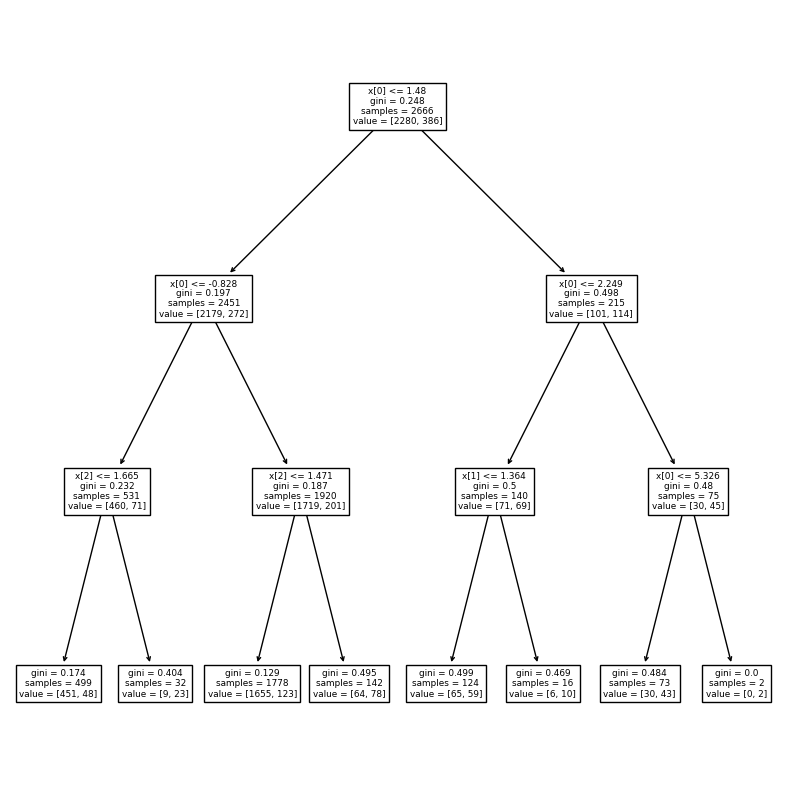

In [86]:
# Plotted the decision tree to visualize results.
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(dt_top, ax=ax);

In [87]:
important_features[0]

'customer service calls'

Interpretation: Customer service is the most important feature, accounting for both the first and second branches of the decision tree. If a client has called customer service more than once, they are more likely to leave. 2280 customers have called once or less, while 386 have called more than once.

### Customer Service Calls Probability Interpretation

In [57]:
#Running logistic regression on just Customer Service Calls (csc)
important_features = ["customer service calls"]
X_csc = df[important_features]
y_csc = df["churn"]
X_train_csc, X_test_csc, y_train_csc, y_test_csc = train_test_split(X_csc, y_csc, test_size=0.2, random_state=12345, stratify=y)

In [58]:
# Scaling, transforming, and fitting.
scaler = StandardScaler()
X_train_csc = scaler.fit_transform(X_train_csc)
X_test_csc = scaler.transform(X_test_csc)

In [59]:
# Prepared the optimal logistic regression for the feature.
lr = LogisticRegression(random_state=12345)

solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [2, 5, 10, 25]

param = {'solver': solver, 'max_iter': max_iter}

grid_search = GridSearchCV(lr, param, cv=5, scoring='f1')

grid_search.fit(X_train_csc, y_train_csc)

print("best_lr_model:", grid_search.best_estimator_)


best_lr_model: LogisticRegression(max_iter=5, random_state=12345, solver='newton-cg')


In [60]:
# Ran optimized logistic regression for csc.
lr_csc = LogisticRegression(max_iter=5, random_state=12345, solver='newton-cg')

lr_csc_scores = cross_val_score(lr_csc, X_train_csc, y_train_csc, cv=5, scoring="accuracy", error_score='raise')

lr_csc.fit(X_train_csc, y_train_csc)

lr_csc_predict_train = cross_val_predict(lr_csc, X_train_csc, y_train_csc, cv=5)
lr_csc_predict_test = cross_val_predict(lr_csc, X_test_csc, y_test_csc, cv=5)

print("lr_csc_f1_train:", f1_score(y_train_csc,lr_csc_predict_train))
print("lr_csc_f1_test:", f1_score(y_test_csc,lr_csc_predict_test))
print("lr_csc_accuracy_train:", accuracy_score(y_train_csc,lr_csc_predict_train))
print("lr_csc_accuracy_test:", accuracy_score(y_test_csc,lr_csc_predict_test))
print("lr_csc_mean_accuracy:", lr_csc_scores.mean())

lr_csc_f1_train: 0.030226700251889164
lr_csc_f1_test: 0.06000000000000001
lr_csc_accuracy_train: 0.8555888972243061
lr_csc_accuracy_test: 0.8590704647676162
lr_csc_mean_accuracy: 0.8555881133573651


In [61]:
logodds = lr_csc.intercept_
odds = np.exp(logodds)
prob = odds / (1 + odds)
prob

array([0.13314543])

Interpretation: Every call a client makes to customer service makes them 13.31% more likely to leave SyriaTel.

### International Plan Probability Interpretation

In [62]:
#Running logistic regression on just International Plan Yes (ipy)
important_features = ['international plan_yes']
X_ipy = df[important_features]
y_ipy = df['churn']
X_train_ipy, X_test_ipy, y_train_ipy, y_test_ipy = train_test_split(X_ipy, y_ipy, test_size=0.2, random_state=12345, stratify=y)

In [63]:
# Scaling, transforming, and fitting.
scaler = StandardScaler()
X_train_ipy = scaler.fit_transform(X_train_ipy)
X_test_ipy = scaler.transform(X_test_ipy)

In [64]:
# Prepared the optimal logistic regression for the feature.
lr = LogisticRegression(random_state=12345)

solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [2, 5, 10, 25]

param = {'solver': solver, 'max_iter': max_iter}

grid_search = GridSearchCV(lr, param, cv=5, scoring='f1')

grid_search.fit(X_train_ipy, y_train_ipy)

print("best_lr_model:", grid_search.best_estimator_)


best_lr_model: LogisticRegression(max_iter=2, random_state=12345, solver='saga')


In [65]:
# Ran optimized logistic regression for ipy.
lr_ipy = LogisticRegression(max_iter=2, random_state=12345, solver='saga')

lr_ipy_scores = cross_val_score(lr_ipy, X_train_ipy, y_train_ipy, cv=5, scoring="accuracy", error_score='raise')

lr_ipy.fit(X_train_ipy, y_train_ipy)

lr_ipy_predict_train = cross_val_predict(lr_ipy, X_train_ipy, y_train_ipy, cv=5)
lr_ipy_predict_test = cross_val_predict(lr_ipy, X_test_ipy, y_test_ipy, cv=5)

print("lr_ipy_f1_train:", f1_score(y_train_ipy,lr_ipy_predict_train))
print("lr_ipy_f1_test:", f1_score(y_test_ipy,lr_ipy_predict_test))
print("lr_ipy_accuracy_train:", accuracy_score(y_train_ipy,lr_ipy_predict_train))
print("lr_ipy_accuracy_test:", accuracy_score(y_test_ipy,lr_ipy_predict_test))
print("lr_ipy_mean_accuracy:", lr_csc_scores.mean())

lr_ipy_f1_train: 0.2420856610800745
lr_ipy_f1_test: 0.0
lr_ipy_accuracy_train: 0.8473368342085521
lr_ipy_accuracy_test: 0.8545727136431784
lr_ipy_mean_accuracy: 0.8555881133573651


In [66]:
logodds = lr_ipy.intercept_
odds = np.exp(logodds)
prob = odds / (1 + odds)
prob

array([0.14786223])

Interpretation: Having the international plan makes customers 14.79% more likely to leave SyriaTel.

### Total Day Minutes Probability Interpretation


In [67]:
#Running logistic regression on just Total Day Minutes (mins).
important_features = ['total day minutes']
X_mins = df[important_features]
y_mins = df['churn']
X_train_mins, X_test_mins, y_train_mins, y_test_mins = train_test_split(X_mins, y_mins, test_size=0.2, random_state=12345, stratify=y)

In [68]:
# Scaling, transforming, and fitting.
scaler = StandardScaler()
X_train_mins = scaler.fit_transform(X_train_mins)
X_test_mins = scaler.transform(X_test_mins)

In [69]:
# Prepared the optimal logistic regression for the feature.
lr = LogisticRegression(random_state=12345)

solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [2, 5, 10, 25]

param = {'solver': solver, 'max_iter': max_iter}

grid_search = GridSearchCV(lr, param, cv=5, scoring='f1')

grid_search.fit(X_train_mins, y_train_mins)

print("best_lr_model:", grid_search.best_estimator_)


best_lr_model: LogisticRegression(max_iter=2, random_state=12345, solver='sag')


In [70]:
# Ran optimized logistic regression for mins.
lr_mins = LogisticRegression(max_iter=2, random_state=12345, solver='sag')

lr_mins_scores = cross_val_score(lr_mins, X_train_mins, y_train_mins, cv=5, scoring="accuracy", error_score='raise')

lr_mins.fit(X_train_mins, y_train_mins)

lr_mins_predict_train = cross_val_predict(lr_mins, X_train_mins, y_train_mins, cv=5)
lr_mins_predict_test = cross_val_predict(lr_mins, X_test_mins, y_test_mins, cv=5)

print("lr_mins_f1_train:", f1_score(y_train_mins,lr_mins_predict_train))
print("lr_mins_f1_test:", f1_score(y_test_mins,lr_mins_predict_test))
print("lr_mins_accuracy_train:", accuracy_score(y_train_mins,lr_mins_predict_train))
print("lr_mins_accuracy_test:", accuracy_score(y_test_mins,lr_mins_predict_test))
print("lr_mins_mean_accuracy:", lr_csc_scores.mean())

lr_mins_f1_train: 0.18013856812933027
lr_mins_f1_test: 0.0
lr_mins_accuracy_train: 0.8668417104276069
lr_mins_accuracy_test: 0.8545727136431784
lr_mins_mean_accuracy: 0.8555881133573651


In [72]:
logodds = lr_mins.intercept_
odds = np.exp(logodds)
prob = odds / (1 + odds)
prob

array([0.12865314])

Interpretation: Every additional minute on the phone makes users 12.86% more likely to leave SyriaTel.

### Both International & Customer Service Interpretation

In [74]:
#Running logistic regression on international plans and customer service calls (both).
important_features = ['international plan_yes', 'customer service calls']
X_both = df[important_features]
y_both = df['churn']
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(X_both, y_both, test_size=0.2, random_state=12345, stratify=y)

In [75]:
# Scaling, transforming, and fitting.
scaler = StandardScaler()
X_train_both = scaler.fit_transform(X_train_both)
X_test_both = scaler.transform(X_test_both)

In [77]:
# Prepared the optimal logistic regression for the feature.
lr = LogisticRegression(random_state=12345)

solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [2, 5, 10, 25]

param = {'solver': solver, 'max_iter': max_iter}

grid_search = GridSearchCV(lr, param, cv=5, scoring='f1')

grid_search.fit(X_train_both, y_train_both)

print("best_lr_model:", grid_search.best_estimator_)


best_lr_model: LogisticRegression(max_iter=5, random_state=12345)


In [78]:
# Ran optimized logistic regression for mins.
lr_both = LogisticRegression(max_iter=5, random_state=12345, solver='sag')

lr_both_scores = cross_val_score(lr_both, X_train_both, y_train_both, cv=5, scoring="accuracy", error_score='raise')

lr_both.fit(X_train_both, y_train_both)

lr_both_predict_train = cross_val_predict(lr_both, X_train_both, y_train_both, cv=5)
lr_both_predict_test = cross_val_predict(lr_both, X_test_both, y_test_both, cv=5)

print("lr_both_f1_train:", f1_score(y_train_both,lr_both_predict_train))
print("lr_both_f1_test:", f1_score(y_test_mins,lr_both_predict_test))
print("lr_both_accuracy_train:", accuracy_score(y_train_both,lr_both_predict_train))
print("lr_both_accuracy_test:", accuracy_score(y_test_both,lr_both_predict_test))
print("lr_both_mean_accuracy:", lr_both_scores.mean())

lr_both_f1_train: 0.1806451612903226
lr_both_f1_test: 0.07547169811320753
lr_both_accuracy_train: 0.8570892723180795
lr_both_accuracy_test: 0.8530734632683659
lr_both_mean_accuracy: 0.8570911595027791


In [80]:
logodds = lr_both.intercept_
odds = np.exp(logodds)
prob = odds / (1 + odds)
prob

array([0.12966399])

Interpretation: If you have the international plan, each additional call to customer service raises your probability of leaving SyriaTel by 12.97%.

## Summary

In Conclusion, our best model was the Light GBM model with SMOTE, it had an accuracy score of roughly 87%. The important features that informed this model were if clients had an international plan, how many minutes they talked on the phone during the day, and how many calls they made to customer service. These three features accounted for 60% churn.

The importance of these features was explored in a decision tree and individual logistic regressions. We discovered that each additional call to customer service makes a client 13% more likely to leave SyriaTel, while the Decision Tree made it clear that all values are categorized 'churn' after the 5th call.

These findings allow us to make some recommendations, such as to support customer service representatives so that they can best meet the needs of our clients. Along with this, further research into qualms with the international plan will allow us to better respond to customer needs.

Next steps might include adding DateTime information to accounts, so we can best track the relevancy of these issues. Along with that, pairing with an NLP model of online reviews would make it possible to see customer feedback, a weakness in the current dataframe.